# Downsampling data with <i>kite</i>

The <i><a href="https://pyocko.org">pyrocko</a></i> suite of tools comprise a series of open source applications designed to simplify the modeling of earthquakes, using both seismic and InSAR data. Here we will use one of those applications, <i>kite</i>, to read in and downsample an ISCE interferogram using quadtree decomposition.

## Setup (optional)

First, install some dependencies, if you haven't already...

In [ ]:
# the kite and pyrocko codes - ignore if you already have these installed!
!pip install pyrocko
!pip install utm
!pip install git+https://github.com/pyrocko/kite

...and import the necessary dependencies: 

In [1]:
import numpy as np
from kite import Scene
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
from osgeo import gdal
import utm

We will use, for this exercise, a pre-processed interferogram of the 2020 M6.7 Elazig earthquake in Turkey. Let's grab it (and some other key files) off of the cloud! (This workflow should work for any ISCE-processed interferogram though.)

In [ ]:
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.vrt .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.xml .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo.vrt .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo.xml .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/water.msk .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/water.msk.vrt .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/water.msk.xml .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo.vrt .
!aws --region us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo.xml .

download: s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo to ./filt_topophase.unw.geo
download: s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.vrt to ./filt_topophase.unw.geo.vrt
download: s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.xml to ./filt_topophase.unw.geo.xml
download: s3://asf-jupyter-data/Elazig/los.rdr.geo to ./los.rdr.geo 
download: s3://asf-jupyter-data/Elazig/los.rdr.geo.vrt to ./los.rdr.geo.vrt
download: s3://asf-jupyter-data/Elazig/los.rdr.geo.xml to ./los.rdr.geo.xml
download: s3://asf-jupyter-data/Elazig/water.msk to ./water.msk    
download: s3://asf-jupyter-data/Elazig/water.msk.vrt to ./water.msk.vrt
download: s3://asf-jupyter-data/Elazig/water.msk.xml to ./water.msk.xml
download: s3://asf-jupyter-data/Elazig/topophase.cor.geo to ./topophase.cor.geo
download: s3://asf-jupyter-data/Elazig/topophase.cor.geo.vrt to ./topophase.cor.geo.vrt


Next, we specify a path and some filenames:

In [2]:
ifgpath="./"                     # directory with your interferogram
ifgname="filt_topophase.unw.geo"                                      # interferogram file
corname="topophase.cor.geo"                                           # correlation file
lospath=ifgpath                                                       # can specify different path for los information
losname="los.rdr.geo"                                                 # line-of-sight file
mskname="water.msk"                                                   # water mask file (optional)
use_water_mask=True

outbase="elazig_asc"                                                  # output filename base

Here are a couple of important parameters. <i>kite</i> currently cannot read in the radar wavelength from the interferogram metadata, as it is not included in the xml file(!) and so we specify it here. We also supply a correlation threshold for masking out low correlation data points.

In [3]:
wavel = 0.0555     # radar wavelength in m
cor_thresh = 0.25  # correlation threshold between 0 (bad) and 1 (perfect)

## Load in the interferogram

<i>kite</i> has a single command to read in an interferogram from ISCE (see below), but manual import is more flexible and powerful, allowing for cropping and masking. We make use of all of that functionality here. The steps are:

- Read in the interferogram, correlation and LOS files (and optionally apply a water mask)
- Plot the input interferogram in image coordinates
- Specify crop bounds in image coordinates if you want
- Convert to displacement in meters and apply a correlation mask
- Extract coordinate system metadata from the imported images
- Crop the images and import them into a <i>kite</i> scene object

In [4]:
# that single command, for reference
#sc = Scene.import_data(ifgpath+ifgname)

Assuming we want to do everything manually, first we read in the interferogram using gdal, and plot it up with matplotlib to see if we want to crop it:

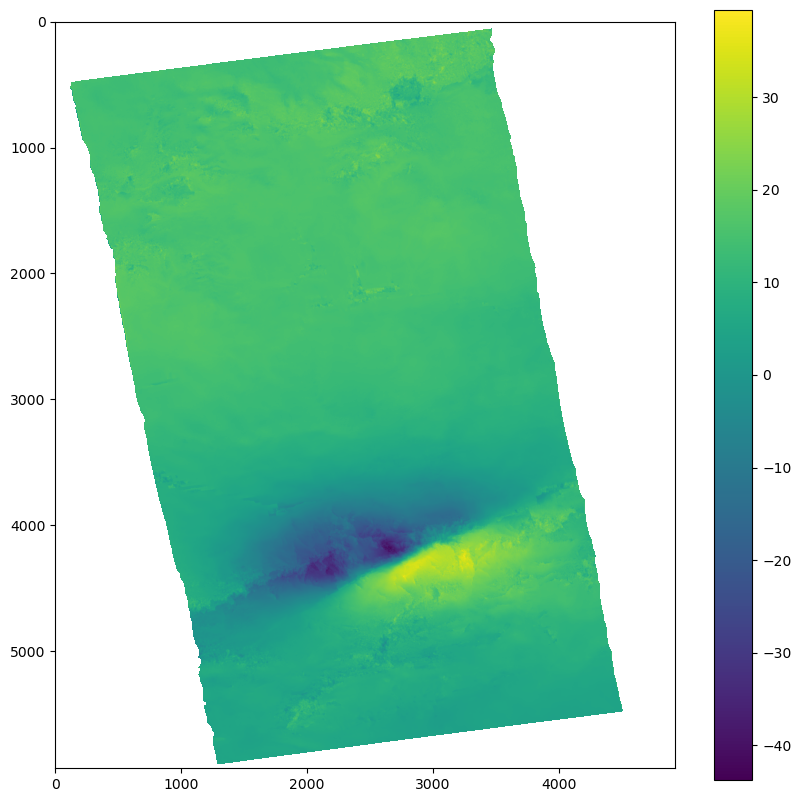

In [5]:
# load in your data manually!

# unwrapped interferogram
ifgfile=gdal.Open(ifgpath+ifgname,gdal.GA_ReadOnly)   # open with gdal
rb = ifgfile.GetRasterBand(2)                         # phase info is in band 2
ifg = rb.ReadAsArray()                                # read it in as a number array

# let's plot it to have a look
### matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(ifg,origin='upper')             # plot displacements with origin at upper left (ISCE default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

If you want to crop it, specify the bounds here. And we will apply it, and all of the other steps, in the code below! 

In [6]:
# specify crop bounds (in image coordinates, e.g. from mdx, in pixels from the top left)
# for the full scene, set minima to 0 and maxima to -1
ymin=0
ymax=-1
xmin=0
xmax=-1

ifg=np.flip(ifg,0)                                    # flip your interferogram to account for origin position
                                                      # (kite prefers lower left; ISCE, top left)
# correlation file
corfile=gdal.Open(ifgpath+corname,gdal.GA_ReadOnly)   # open with gdal
rb = corfile.GetRasterBand(2)                         # correlation info is in band 2
cor = rb.ReadAsArray()                                # read it in as a number array
cor=np.flip(cor,0)                                    # flip image to account for origin position
                                                      # (kite prefers lower left; ISCE, top left)
# line-of-sight information
losfile=gdal.Open(lospath+losname,gdal.GA_ReadOnly)   # open with gdal
rb = losfile.GetRasterBand(1)                         # incidence info is in band 1
inc = rb.ReadAsArray()                                # read it in as a number array
inc=np.flip(inc,0)
rb = losfile.GetRasterBand(2)                         # phase info is in band 2
azi = rb.ReadAsArray()                                # read it in as a number array
azi=np.flip(azi,0)   
    
# apply the water mask, if you have one
if use_water_mask==True:
    # water mask file
    mskfile=gdal.Open(ifgpath+mskname,gdal.GA_ReadOnly)  
    rb = mskfile.GetRasterBand(1)                         # only one band here
    msk = rb.ReadAsArray()
    msk=np.flip(msk,0)    
    ifg[msk<1]=np.nan                                     # mask out water


# convert displacements to meters and mask low correlation pixels
ifg*=wavel/4/math.pi                # change values of sc.displacement in place
ifg[cor<cor_thresh]=np.nan          # mask out low correlation

# get metadata for the image: frame size, pixel size and reference point
gt = losfile.GetGeoTransform()    # geotransform information
nrows=losfile.RasterYSize

# sort out the maximum crop size in the y direction
if ymax==-1:
    ymax=nrows

# now for the kite part...
    
# initiate your kite scene object
sc = Scene()
    
# specify pixel spacing information
sc.frame.spacing = 'degree'
sc.frame.dN = abs(gt[5])
sc.frame.dE = gt[1]

# set your reference point
sc.frame.llLat = gt[3]+ymax*gt[5]
sc.frame.llLon = gt[0]+xmin*gt[1]

# read your interferogram and LOS information into the scene object (and crop!)
sc.displacement=ifg[nrows-ymax:nrows-ymin,xmin:xmax]
sc.theta=np.radians(90-inc[nrows-ymax:nrows-ymin,xmin:xmax])
sc.phi=np.radians(90+azi[nrows-ymax:nrows-ymin,xmin:xmax])
    

We can look and see what we imported into <i>kite</i> using matplotlib...

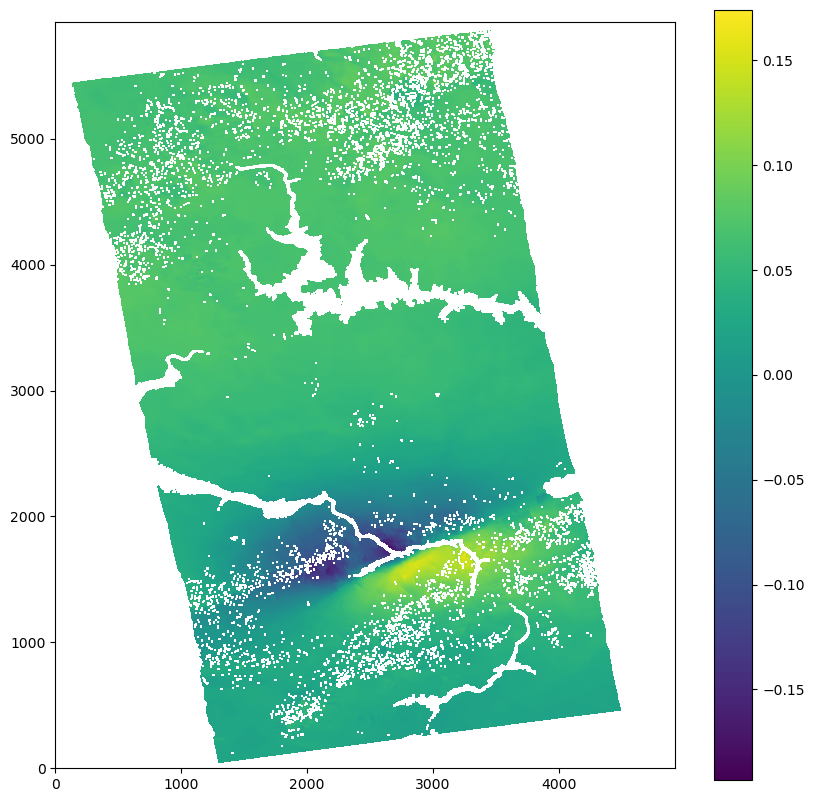

In [7]:
### matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(sc.displacement,origin='lower') # plot displacements with origin at lower left (kite default)
fig.colorbar(im)                                # plot a color bar!
plt.show()

## Quadtree decomposition

We can initialize the quadtree decomposition in <i>kite</i> by defining an abbreviation:

In [8]:
qt = sc.quadtree

And we can specify some parameters that control the quadtree process:

In [11]:
qt.epsilon = 0.02         # Variance threshold
qt.nan_allowed = 0.5      # Percentage of NaN values allowed per tile/leaf
qt.tile_size_max = 0.2    # Maximum leaf size in degrees
qt.tile_size_min = 0.01  # Minimum leaf size in degrees

Let's look at the distribution of leaves/tiles. Typically we are looking for a few hundred... If you don't like what you have, try editing the values above and re-running. If you would like more leaves, lower the epsilon value and/or make the tile sizes smaller. If you want fewer, do the opposite!

In [12]:
print("There are",qt.nleaves,"leaves")

There are 194 leaves


And if you want to see the quadtree results, you can. This example prints out the leaf number, the lower left ('ll') east and north coordinates of the leaf (with respect to the lower left of the whole image), and the mean displacement of the pixels in that leaf:

In [13]:
j=0
for k in qt.leaves:
    print("leaf",j,"llE:",qt.leaves[j].llE,"llN:",qt.leaves[j].llN,"mean:",qt.leaves[j].mean) 
    j=j+1

leaf 0 llE: 0.28444444444444444 llN: 0.0 mean: 0.022180622443556786
leaf 1 llE: 0.42666666666666664 llN: 0.0 mean: 0.02744920924305916
leaf 2 llE: 0.28444444444444444 llN: 0.14222222222222222 mean: 0.01807079277932644
leaf 3 llE: 0.42666666666666664 llN: 0.14222222222222222 mean: 0.02462043985724449
leaf 4 llE: 0.28444444444444444 llN: 0.28444444444444444 mean: 0.005144493188709021
leaf 5 llE: 0.42666666666666664 llN: 0.28444444444444444 mean: -0.0013355240225791931
leaf 6 llE: 0.49777777777777776 llN: 0.28444444444444444 mean: 0.014465592801570892
leaf 7 llE: 0.42666666666666664 llN: 0.35555555555555557 mean: -0.043860964477062225
leaf 8 llE: 0.49777777777777776 llN: 0.35555555555555557 mean: -0.031142612919211388
leaf 9 llE: 0.5333333333333333 llN: 0.35555555555555557 mean: -0.019963648170232773
leaf 10 llE: 0.49777777777777776 llN: 0.39111111111111113 mean: -0.08187218010425568
leaf 11 llE: 0.5333333333333333 llN: 0.39111111111111113 mean: -0.06455549597740173
leaf 12 llE: 0.5511111

And you can plot them too!

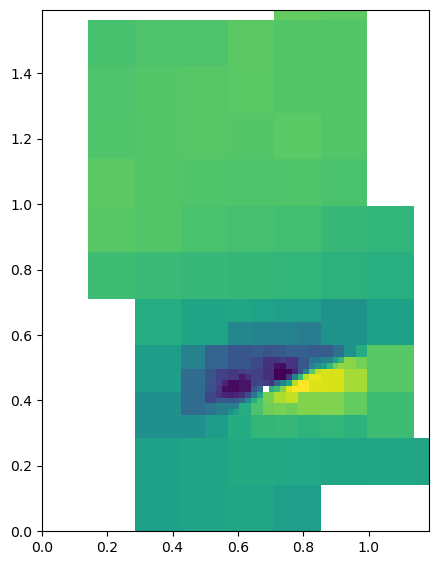

In [14]:
#matplotlib inline
fig, ax3 = plt.subplots(figsize=[5,7.5])

ulimit = qt.leaf_medians.max()
llimit = qt.leaf_medians.min()

color_map = cm.ScalarMappable(
    norm=colors.Normalize(vmin=llimit, vmax=ulimit))

for rect, leaf in zip(qt.getMPLRectangles(), qt.leaves):
    color = color_map.to_rgba(leaf.median)
    rect.set_facecolor(color)
    ax3.add_artist(rect)


ax3.set_xlim(0, qt.leaf_eastings.max())
ax3.set_ylim(0, qt.leaf_northings.max())
ax3.set_aspect('equal')


plt.show();

## Processing the quadtree output

There are several modeling codes out there for InSAR data, and there is no standard data input format. But typically, all such modeling codes will need (at a minimum) data point locations, displacements and line-of-sight vector information.

Here is an example of reformatting the output of the <i>kite</i> quadtree decomposition for use in one such code, <i>okinv</i>. This involves extracting the quadtree leaf centroids and displacement averages in their lat-long coordinates, and then converting them to a local coordinate system (a UTM system, with coordinates specified in kilometers). We also include the LOS vector information for each of these points. Hopefully this is straightforward enough to follow that you can reformat the data for use in other codes, if necessary!

The steps involved here:

- Convert the reference point from lat-long coordinates to UTM
- Compute the three components of the unit LOS vector for each pixel
- Convert the positions of the rest of the points to UTM, and plot them

The reference point in <i>kite</i> is the lower left (SW) corner of the interferogram. (Note that <i>ISCE</i>, and indeed most geospatial imaging formats, use the upper left corner.) We can use the <i>utm</i> code to convert them to rectilinear coordinates:

In [15]:
reflat=sc.frame.llLat
reflon=sc.frame.llLon

# we would also like the reference point in utm coordinates
refutm=utm.from_latlon(reflat,reflon)

print("reference point (lat-long):",reflat,"N",reflon,"E")

print("reference point (utm):",refutm[0],"E",refutm[1],"N")

reference point (lat-long): 37.84527777777778 N 38.219166666666666 E
reference point (utm): 431300.6052827784 E 4188935.7115277294 N


Extracting the information we need from <i>kite</i>'s output is fairly straightforward. 'leaf_focal_points' is the name given to the centers of each quadtree cell, and is provided both in meters in a local coordinate system, as well as in long-lat.

The definitions of incidence ('qt.leaf_thetas') and azimuth ('qt.leaf_phis') in kite are a little unusual (as seems to be common in InSAR, everyone has their own convention!) Here, the convention is up-looking, towards the satellite, with the azimuth being counter-clockwise from the East. Both values are in radians.

We can convert this fairly easily to other definitions such as 'range change', i.e. with the unit line-of-sight (LOS) vector pointing from the satellite to the ground target, by doing some simple trigonometry. (It is probably a good idea to draw the problem, to see how this works...)

In [16]:
# xy positions of data points in long-lat
xyll=np.column_stack((qt.leaf_focal_points[:,0]+reflon,qt.leaf_focal_points[:,1]+reflat))

# los vector components using kite definiton of coordinates
losx=np.cos(qt.leaf_thetas)*-np.cos(qt.leaf_phis)
losy=np.cos(qt.leaf_thetas)*-np.sin(qt.leaf_phis)
losz=-np.sin(qt.leaf_thetas)

# okinv format includes an id label for each datapoint
dataptid=np.arange(1,losx.size+1)

# and finally let's convert our lat-long coordinates to UTM km
xym = utm.from_latlon(xyll[:,1],xyll[:,0]) 
xkm = xym[0]/1000
ykm = xym[1]/1000

We can plot the points, just to make sure that our conversion makes sense:

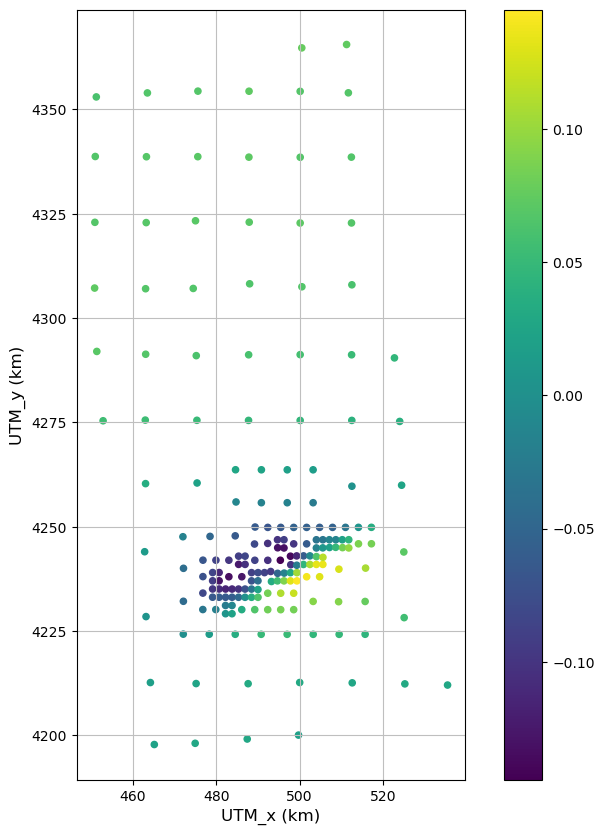

In [17]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.set_xlabel("UTM_x (km)",fontsize=12)
ax.set_ylabel("UTM_y (km)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
im=ax.scatter(xkm,ykm,s=20,c=qt.leaf_means, marker = 'o');
#im=ax.scatter(xkm,ykm,s=20,c=qt.leaf_means, marker = 'o', cmap = cm.jet); # if you prefer jet
ax.set_aspect('equal')
fig.colorbar(im) 

plt.show()

## Saving the output

We finish by outputting the data to file, in one example format. The following format, based on the okinv code, has seven columns:

\<x_coordinate(km)\>  \<y_coordinate(km)\>  \<los_displacement(m)\>  \<unit_los_x\>  \<unit_los_y\>  \<unit_los_z\>  \<id\>

In [18]:
# okinv format in km
okinv_data=np.column_stack((xkm,ykm,qt.leaf_means,losx,losy,losz,dataptid))
outfile=outbase+".okinv"
np.savetxt(outfile,okinv_data,fmt='%f %f %f %f %f %f %d')

Alternatively, if your code prefers it (and ours does not), you can save the data in long-lat coordinates:

\<longitude\> \<latitude\> \<los_displacement(m)\> \<unit_los_x\> \<unit_los_y\> \<unit_los_z\> \<id\>

In [19]:
# okinv-equivalent format in lat-long coordinates 
okinv_data_ll=np.column_stack((xyll,qt.leaf_means,losx,losy,losz,dataptid))
outfile=outbase+"_ll"+".okinv"
np.savetxt(outfile,okinv_data_ll,fmt='%f %f %f %f %f %f %d')

We can also, optionally, save the data in <i>kite</i>'s internal format, and (potentially, per the <i>kite</i> manual) in a comma-separated variable file:

In [ ]:
# save the scene information in a single file
sc.save(outbase)
# export the quadtree information in a CSV file
# qt.export(outbase+'.csv')   # not working for me right now...